# Goal

The goal of this notebook is to train a 3d UNET segmentation model to output binary mask representing the sella turcica ROI.

Notes:
- following https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

# Prelim

Check python version

In [1]:
# get python version
from platform import python_version
print(python_version())

3.7.4


Check whether GPU enabled.

In [2]:
# Check GPU stats

from pynvml import *
nvmlInit()
try:
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
except NVMLError as error:
    print(error)
    
# https://docs.fast.ai/dev/gpu.html
import nvidia_smi

nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

res = nvidia_smi.nvmlDeviceGetUtilizationRates(handle)
print(f'gpu: {res.gpu}%, gpu-mem: {res.memory}%')

import torch
print("is cuda available?", torch.cuda.is_available() )
torch.cuda.empty_cache()
torch.cuda.set_device(0)

# hm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Device 0 : b'GeForce GTX 1080 Ti'
Device 1 : b'GeForce GTX 1080'
gpu: 0%, gpu-mem: 0%
is cuda available? True
cuda


# Data Path

Set path to where data is stored.

In [3]:
# Get path to 4 TB HD

# /media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home

# wsl: /home/rgologorsky/DeepPit
hd_path = "../" * 5 + "/media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a" + "/home/rachel/PitMRdata"

# all folders in HD
all_folders = os.listdir(hd_path)

print(all_folders)

# labels
print(os.listdir(f"{hd_path}/samir_labels"))

['ABIDE', 'PPMI', 'ABVIB', 'samir_labels']
['50155-50212', '50373-50453', '50002-50153', '50213-50312', '50313-50372']


# Imports

In [4]:
# imports

from faimed3d.all import *
from fastai import *
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

import os
import time
import pickle
from pathlib import Path

import SimpleITK as sitk

import numpy as np
import pandas as pd
from pandas import DataFrame as DF

from helpers_preprocess import get_data_dict, paths2objs, folder2objs

from helpers_general import sitk2np, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups

# imports
from helpers_general import sitk2np, np2sitk, round_tuple, lrange, get_roi_range, numbers2groups
from helpers_preprocess import mask2bbox, print_bbox, get_bbox_size, print_bbox_size, get_data_dict, folder2objs
from helpers_viz import viz_axis

# Get Items

Item = (path to MR, path to Segmentation obj)

In [5]:
# get items = (mask_fn, nii_fn)
train_path = f"{hd_path}/samir_labels/50155-50212/"
data_dict_full = get_data_dict(train_path)

# subset 5 items to test
n_items   = 10
data_dict = {k:v for k,v in list(data_dict_full.items())[:n_items]}
items     = list(data_dict.values())

## Metadata

Check size, spacing, etc of the items in the dataset.

In [6]:
# load metadata about fns -- size, spacing, etc
full_metadata_df = pd.read_pickle("./50155-50212.pkl")

# filter to items in our dataset
fns = [mr for mr, mk in items]
metadata_df = full_metadata_df[full_metadata_df.fn.isin(fns)]

#metadata_df

What are the different sizes and spacings in the dataset?

In [7]:
# which sizes are represented?
szs = np.array(list(metadata_df.sz.values))
sps = np.array(list(metadata_df.sp.values))
dirs = np.array(list(metadata_df.dir.values))
def print_unique(vals, sep="*" * 30):
    unique, idxs, cnts = np.unique(vals, return_index=True, return_inverse=False, return_counts=True, axis=0)
    print(sep)
    print("Num unique = ", len(unique))
    print("Unique: ", *unique, sep=" ")
    print("Counts: ", *cnts, sep = " ")
    print("Idxs: ", idxs, sep = " ")
    print(sep)
    
print("Sizes:"); print_unique(szs)
print("Spacings:"); print_unique(sps)
print("Dirs:"); print_unique(dirs)

Sizes:
******************************
Num unique =  2
Unique:  [160 239 200] [172 256 256]
Counts:  3 7
Idxs:  [1 0]
******************************
Spacings:
******************************
Num unique =  2
Unique:  [1. 1. 1.] [1.1 1.  1. ]
Counts:  7 3
Idxs:  [0 1]
******************************
Dirs:
******************************
Num unique =  1
Unique:  [ 1  0  0  0 -1  0  0  0  1]
Counts:  10
Idxs:  [0]
******************************


## Mask Bbox

Goal: find the range of slice indices that captures the sella of all inputs. Within a single standardized dataset, the slice indices should be similar.

Why? A full MR volume has >100 slices. The sella occupies about 10 of them. For quick testing, want the input to be MR with 20 slices and not >100 slices.

In [8]:
# # list of all bboxs
# ims, mks = zip(*[PathToSitk()(i) for i in items])
# bboxs = [mask2bbox(sitk2np(mk)) for mk in mks]
# descr = ["imin", "imax", "jmin", "jmax", "kmin", "kmax"]

# def bb_dict(bbox): return dict(zip(descr, bbox))

# # dataframe of imin/imax
# mk_df = DF([{'fn': mr, **bb_dict(bboxs[i])} \
#             for i,(mr, mk) in enumerate(items)])

# # irange is 62-108; jrange = 118-181; krange = 60-144
# # => islices 50-150, jslices 100-200, kslices 0-200
# for col in ("i", "j", "k"):
#     col_min = mk_df[f"{col}min"].min()
#     col_max = mk_df[f"{col}max"].max()
#     print(f"{col} ROI Range: {col_min} - {col_max}")

# # plot slice range
# #mk_df.boxplot(column=descr)

# Transforms

- PathToSITK (*convert paths to SITK obj*)
- Resize (*common size, isotropic spacing*)
- ToTensor (*convert to Pytorch tensor*)
- TensorSlice & Center Crop (*slice 3d tensor to center part containing sella*)
- Normalize (*scale image intensities? - diff tissues diff intensities?*)

In [36]:
import meshio
from helpers_preprocess import seg2mask

In [77]:
class DoAll(ItemTransform):
    def encodes(self, x, new_sp=1):
        # get sitk objs
        im_path, segm_path = x
        folder  = Path(segm_path).parent.name
        ras_adj = int(folder) in range(50455, 50464)

        mr         = sitk.ReadImage(im_path, sitk.sitkFloat32)
        segm       = meshio.read(segm_path)
        mask_arr   = seg2mask(mr, segm, ras_adj)

        # resize so isotropic spacing
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/new_sp)) for osz,ospc in zip(orig_sz, orig_sp)]

        im = torch.swapaxes(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)
        mk = torch.tensor(mask_arr).float()

        while im.ndim < 5: 
            im = im.unsqueeze(0)
            mk = mk.unsqueeze(0)

        return F.interpolate(im, size = new_sz, mode = 'trilinear', align_corners=False).squeeze(), \
                F.interpolate(mk, size = new_sz, mode = 'nearest').squeeze().float()


# Crop

In [78]:
# crop center
class CenterCropTfm(Transform):
    def __init__(self, size):
        self.size = size
        
    def encodes(self, arr):
        return self.cropND(arr, self.size)
    
    # https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image
    @staticmethod
    def cropND(img, bounding):
        start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
        end = tuple(map(operator.add, start, bounding))
        slices = tuple(map(slice, start, end))
        return img[slices]
    
# crop by coords
class CropBBox(Transform):
    def __init__(self, bbox):
        self.bbox = bbox
    
    def encodes(self, arr):
        imin, imax, jmin, jmax, kmin, kmax = self.bbox
        return arr[imin:imax, jmin:jmax, kmin:kmax]
        

In [79]:
# # test
# tls = TfmdLists(items[0:2], \
#                 [PathToSitk(), \
#                  IsotropicTfm(1), \
#                  ToTensor3D(), \
#                  CenterCropTfm((150, 150, 200))
#                 ])

# im1, mask1 = tls[0]
# im2, mask2 = tls[1]

# # print
# print(type(im1), im1.shape, type(mask1), mask1.shape)
# print(type(im2), im2.shape, type(mask2), mask2.shape)

## Mask Bbox

Goal: find the bbox that captures the general region of the sella. The bbox should be similar within a single standardized dataset.

Why? A full MR volume has >100 slices. The sella occupies about 10 of them. For quick testing, want the input to be MR with 20 slices and not >100 slices.

In [80]:
# tls = TfmdLists(items, \
#                 [PathToSitk(), \
#                  IsotropicTfm(1), \
#                  ToTensor3D(), \
#                 ])

# # list of all bboxs
# ims, mks = list(zip(*tls))
# bboxs = [mask2bbox(np.array(mk)) for mk in mks]
# descr = ["imin", "imax", "jmin", "jmax", "kmin", "kmax"]

# def bb_dict(bbox): return dict(zip(descr, bbox))

# # dataframe of imin/imax
# mk_df = DF([{'fn': mr, **bb_dict(bboxs[i])} \
#             for i,(mr, mk) in enumerate(items)])

# # irange is 66-108; jrange = 118-181; krange = 60-144
# # => islices 50-150, jslices 100-200, kslices 0-200
# for col in ("i", "j", "k"):
#     col_min = mk_df[f"{col}min"].min()
#     col_max = mk_df[f"{col}max"].max()
#     print(f"{col} ROI Range: {col_min} - {col_max}")

# # get general bbox of the sella region
# general_bbox = [x for col in ("i", "j", "k") for x in (mk_df[f"{col}min"].min(), mk_df[f"{col}max"].max())]
# print(general_bbox); print_bbox(*general_bbox)

# # plot slice range
# #mk_df.boxplot(column=descr)

In [81]:
# # test crop
# tls = TfmdLists(items[0:2], \
#                 [PathToSitk(), \
#                  IsotropicTfm(1), \
#                  ToTensor3D(), \
#                  CropBBox(general_bbox)
#                 ])

# ims, mks = list(zip(*tls))

# # print
# for im,mk in zip(ims, mks):
#     print(im.shape, mk.shape)
#     print_bbox(*mask2bbox(np.array(mk)))
#     print()

In [82]:
# # Viz
# idx = 0
# im_np, mk_np = [np.array(x) for x in (ims[idx], mks[idx])]

# viz_axis(np_arr = im_np, \
#         bin_mask_arr  = mk_np, color1 = "yellow", alpha1=0.3, \
#         slices=lrange(0, mk_np.shape[0]), fixed_axis=0, \
#         axis_fn = np.rot90, \
#         title   = "Axis 0", \
         
#         np_arr_b = im_np, \
#         bin_mask_arr_b  = mk_np,
#         slices_b = lrange(0, mk_np.shape[1]), fixed_axis_b=1, \
#         title_b  = "Axis 1", \
         
#         np_arr_c = im_np, \
#         bin_mask_arr_c  = mk_np,
#         slices_c = lrange(0, mk_np.shape[2]), fixed_axis_c=2, \
#         title_c = "Axis 2", \
         
#         ncols = 5, hspace=0.3, fig_mult=2)

# Dataloaders

TODO augmentations.

- dset = tfms applied to items
- splits into training/valid
- bs

In [83]:
# # imin imax jmin jmax kmin kmax
# print(general_bbox)
# print_bbox(*general_bbox)

In [84]:
# np.array((66, 118, 60)) + np.array((42, 93, 93))

# np.array((66, 118, 60)) + np.array((20, 112, 112))

In [85]:
square_bbox = [66, 86, 118, 230, 60, 172]
print("Sq bbox", square_bbox)

Sq bbox [66, 86, 118, 230, 60, 172]


In [86]:
tfms = [DoAll(), CropBBox(square_bbox)]

Pipeline(tfms)

Pipeline: DoAll -> CropBBox

In [91]:
# splits
splits = RandomSplitter(seed=42)(items)
print(f"Training: {len(splits[0])}, Valid: {len(splits[1])}")

# tfms

#tfms = [PathToSitk(), IsotropicTfm(1), ToTensor3D(), CropBBox(square_bbox)] #, AddChannel()]

tfms = [DoAll(), CropBBox(square_bbox)]

# tls
tls = TfmdLists(items, tfms, splits=splits)

# dls
dls = tls.dataloaders(bs=1, after_batch=AddChannel())

# GPU
dls = dls.cuda()

# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(len(dls.train), len(dls.valid))

Training: 8, Valid: 2
<class 'tuple'> torch.Size([1, 1, 20, 112, 112]) torch.Size([1, 1, 20, 112, 112])
8 2


# Metric

Linear combination of Dice and Cross Entropy

In [92]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) /
           (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

In [93]:
# ipython nbconvert --to python  '6 - Dataloaders- NB - Simple-Copy1.ipynb'

# Learner

In [94]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [95]:
backbone = efficientnet_b0 #r3d_18 (pretrained?)
learn    = unet_learner_3d(dls, backbone, n_out=2)

# GPU
learn.model = learn.model.cuda()
learn = learn.to_fp16()

In [96]:
# test:

#dls.device = "cpu"

start = time.time()

x,y = dls.one_batch()
#x,y = to_cpu(x), to_cpu(y)

pred = learn.model(x)
loss = learn.loss_func(pred, y)

elapsed = time.time() - start

print(f"Elapsed: {elapsed}")
print("Batch: x,y")
print(type(x), x.shape, x.dtype, "\n", type(y), y.shape, y.dtype)

print("Pred shape")
print(type(pred), pred.shape, pred.dtype)

print("Loss")
print(loss)
print(learn.loss_func)

Elapsed: 1.1702852249145508
Batch: x,y
<class 'torch.Tensor'> torch.Size([1, 1, 20, 112, 112]) torch.float32 
 <class 'torch.Tensor'> torch.Size([1, 1, 20, 112, 112]) torch.float32
Pred shape
<class 'torch.Tensor'> torch.Size([1, 2, 20, 112, 112]) torch.float32
Loss
tensor(0.5777, device='cuda:0', grad_fn=<MeanBackward0>)


In [97]:
from fastai.callback.all import *
print(learn.show_training_loop())

Start Fit
   - before_fit     : [TrainEvalCallback, MixedPrecision, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [MixedPrecision]
         - after_pred     : [MixedPrecision]
         - after_loss     : [MixedPrecision]
         - before_backward: [MixedPrecision]
         - before_step    : [MixedPrecision]
         - after_step     : [MixedPrecision]
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_va

In [98]:
learn.summary()

DynamicUnet3D (Input shape: 1)
Layer (type)         Output Shape         Param #    Trainable 
                     []                  
ConstantPad3d                                                  
____________________________________________________________________________
                     1 x 32 x 10 x 56 x  
Conv3d                                    864        False     
BatchNorm3d                               64         True      
____________________________________________________________________________
                     []                  
ConstantPad3d                                                  
____________________________________________________________________________
                     1 x 32 x 10 x 56 x  
Conv3d                                    864        False     
BatchNorm3d                               64         True      
SiLU                                                           
ConstantPad3d                                             

# LR Finder

In [107]:
learn.train??

In [105]:
train = learn.dls.train
print(len(train))

8


In [110]:
print("PRE learn.fit one cycle")
learn.fit_one_cycle(1, 1e-7, wd = 1e-4)

PRE learn.fit one cycle


epoch,train_loss,valid_loss,time
0,nan,nan,00:08


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=6.309573450380412e-07)

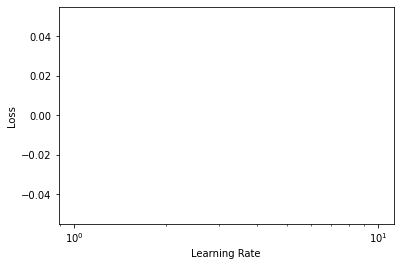

In [72]:
learn.lr_find()

In [ ]:
print("unfreeze, learn 50")
# learn.unfreeze()
# learn.fit_one_cycle(50, 1e-3, wd = 1e-4)